In [104]:
import h5py
import numpy as np
from scipy.stats import linregress

EPSILON = 8

np.set_printoptions(threshold=np.inf)
#c57
#ACTIVE TRIAL
#filename = "./C1_R1v2_ID1v2.mp4.predictions.000_C1_R1v2_ID1v2.analysis.h5"
#PASSIVE TRIALs
#filename = "./C1_R1v4_ID1v3.mp4.predictions.000_C1_R1v4_ID1v3.analysis.h5"
#filename = "./C2_R4v1_ID4v1.mp4.predictions.000_C2_R4v1_ID4v1.analysis.h5"

#CD1
#ACTIVE TRIALS
#filename = "./C6_R1v2_ID1v3.mp4.predictions.slp.000_C6_R1v2_ID1v3.analysis.h5"
#PASSIVE TRIALS
filename = "./C5_R4v1_ID3v4.mp4.predictions.000_C5_R4v1_ID3v4.analysis.h5"

with h5py.File(filename, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]
    track_names = [n.decode() for n in f["track_names"][:]]

print("===filename===")
print(filename)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")

for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

MOUSE_YELLOW_PAGES = dict()
print("===Mouse IDs===")
for i, name in enumerate(track_names):
    print(f"{i}: {name}")
    # it is how you find their number, get it?
    # index to ID, eg: '2.4' -> 0
    MOUSE_YELLOW_PAGES[name] = i
print()


===filename===
./C5_R4v1_ID3v4.mp4.predictions.000_C5_R4v1_ID3v4.analysis.h5

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(57, 6, 2, 2)

===nodes===
0: ear
1: nose
2: tail_base
3: thorax
4: front_foot
5: rear_foot

===Mouse IDs===
0: 5.3
1: 5.4



In [105]:
frame_count, node_count, _, instance_count = locations.shape

print("frame count:", frame_count)
print("node count:", node_count)
print("instance count:", instance_count)

frame count: 57
node count: 6
instance count: 2


In [106]:
from scipy.interpolate import interp1d

def fill_missing(Y, kind="linear"):
    
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))
    print (Y.shape)
    # Interpolate along each slice.
    # 7 mice, 2 dimensions (x,y), 5 nodes - 70 data for each frame
    for i in range(Y.shape[-1]):
        y = Y[:, i]
        print()
        print(f'iteration {i}, y shape {y.shape}')
        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        print(f'x shape: {x.shape}, y[x] shape: {y[x].shape}')
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)
    return Y
locations = fill_missing(locations)

(57, 24)

iteration 0, y shape (57,)
x shape: (55,), y[x] shape: (55,)

iteration 1, y shape (57,)
x shape: (57,), y[x] shape: (57,)

iteration 2, y shape (57,)
x shape: (55,), y[x] shape: (55,)

iteration 3, y shape (57,)
x shape: (57,), y[x] shape: (57,)

iteration 4, y shape (57,)
x shape: (47,), y[x] shape: (47,)

iteration 5, y shape (57,)
x shape: (55,), y[x] shape: (55,)

iteration 6, y shape (57,)
x shape: (47,), y[x] shape: (47,)

iteration 7, y shape (57,)
x shape: (55,), y[x] shape: (55,)

iteration 8, y shape (57,)
x shape: (57,), y[x] shape: (57,)

iteration 9, y shape (57,)
x shape: (57,), y[x] shape: (57,)

iteration 10, y shape (57,)
x shape: (57,), y[x] shape: (57,)

iteration 11, y shape (57,)
x shape: (57,), y[x] shape: (57,)

iteration 12, y shape (57,)
x shape: (57,), y[x] shape: (57,)

iteration 13, y shape (57,)
x shape: (57,), y[x] shape: (57,)

iteration 14, y shape (57,)
x shape: (57,), y[x] shape: (57,)

iteration 15, y shape (57,)
x shape: (57,), y[x] shape:

In [107]:
locations.shape

(57, 6, 2, 2)

In [108]:
#Visualize movement across video
EAR_INDEX = 0
NOSE_INDEX = 1
TAILBASE_INDEX = 2
THORAX_INDEX = 3
FRONT_FOOT_INDEX = 4
REAR_FOOT_INDEX = 5




ear_loc = locations[:, EAR_INDEX, :, :]
nose_loc = locations[:, NOSE_INDEX, :,:]
tail_loc = locations[:, TAILBASE_INDEX, :, :]
thorax_loc = locations[:, THORAX_INDEX, :, :]    
front_foot_loc = locations[:, FRONT_FOOT_INDEX, :, :]
rear_foot_loc = locations[:, REAR_FOOT_INDEX, :, :]

In [109]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [110]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

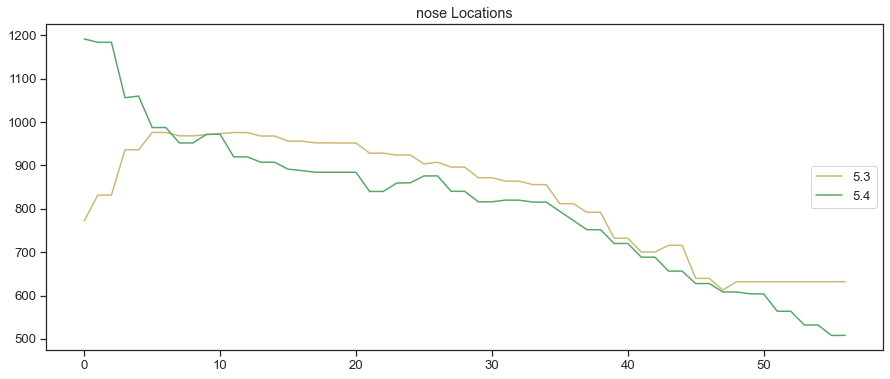

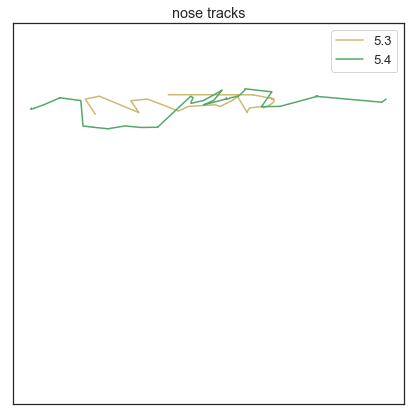

In [82]:
def visualize_tracks(node, node_loc, mouse1, mouse2):
    """
    takes in 4 arguments: 
    node : string; node you want to visualize i.e. 'ear' or 'nose'
    node_loc : a [frames, 2] array
    mouse1 + mouse2 : string; ID name i.e. '1.2'
    returns two plots: locations (only x values) across time (frames) and tracks (all x vs y locations)
    """
    plt.figure()
    plt.plot(node_loc[:,0,MOUSE_YELLOW_PAGES[mouse1]], 'y',label=mouse1)
    plt.plot(node_loc[:,0,MOUSE_YELLOW_PAGES[mouse2]], 'g',label=mouse2)

    #y coordinates which we don't really need since its a more of a one dimensional movement were interested in
    #plt.plot(-1*front_loc[:,1,0], 'y')
    #plt.plot(-1*front_loc[:,1,1], 'g')

    plt.legend(loc="center right")
    plt.title(node + ' Locations')
    plt.savefig('./plots/tracks/id_{}vs{}locations_{}.png'.format(mouse1, mouse2, node))

    plt.figure(figsize=(7,7))
    plt.plot(node_loc[:,0,MOUSE_YELLOW_PAGES[mouse1]],node_loc[:,1,MOUSE_YELLOW_PAGES[mouse1]], 'y',label=mouse1)
    plt.plot(node_loc[:,0,MOUSE_YELLOW_PAGES[mouse2]],node_loc[:,1,MOUSE_YELLOW_PAGES[mouse2]], 'g',label=mouse2)
    plt.legend()

    #plt.xlim(0,1024)
    plt.xticks([])

    plt.ylim(0,1024)
    plt.yticks([])
    plt.title(node + ' tracks')
    plt.savefig('./plots/tracks/id_{}vs{}tracks_{}.png'.format(mouse1, mouse2, node))

visualize_tracks('nose', nose_loc, '5.3', '5.4')

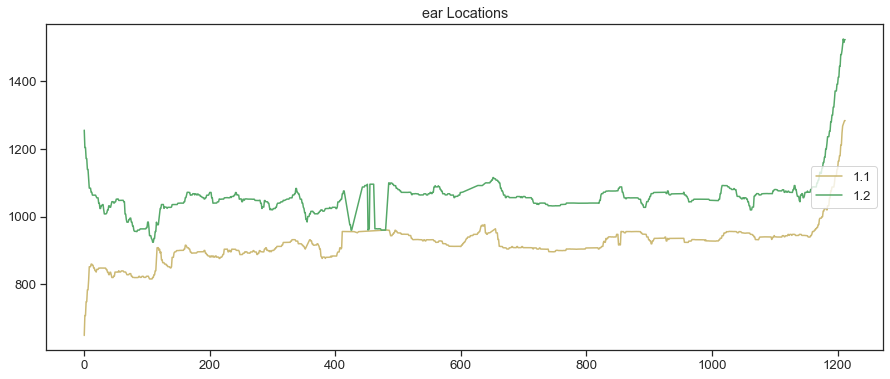

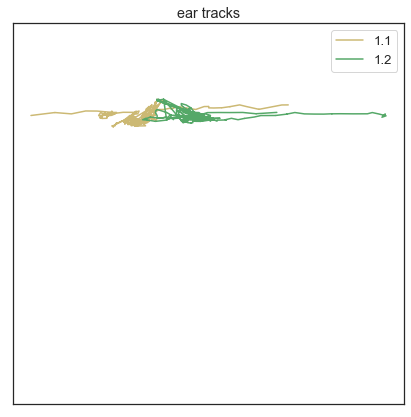

In [43]:
visualize_tracks('ear', ear_loc, '6.1', '6.3')

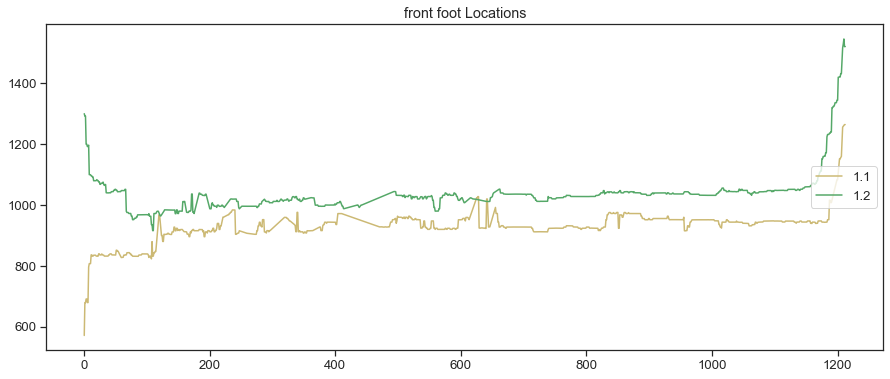

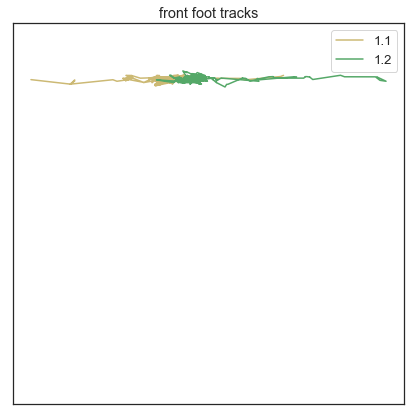

In [44]:
visualize_tracks('front foot', front_foot_loc, '1.1', '1.2')

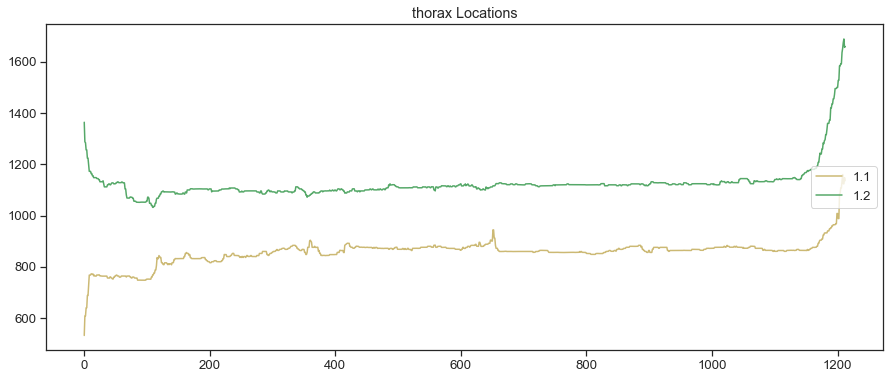

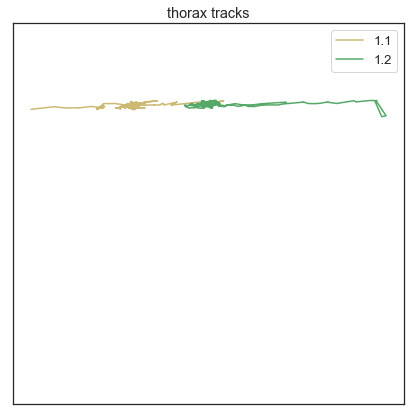

In [45]:
visualize_tracks('thorax', thorax_loc, '1.1', '1.2')

In [46]:
from scipy.signal import savgol_filter

def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
    
    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

In [47]:
X_INDEX = 0
Y_INDEX = 1

print(max(front_loc[:, X_INDEX, MOUSE_YELLOW_PAGES['2.4']]))
max(front_loc[:, Y_INDEX, MOUSE_YELLOW_PAGES['2.4']])




NameError: name 'front_loc' is not defined

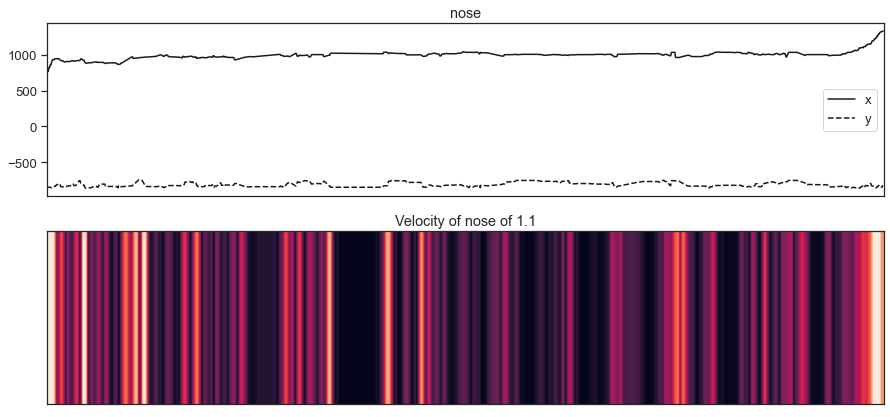

In [31]:
def visualize_velocity(node, node_loc, mouse):
    """
    node: string of node you want to visualize the velocity of i.e. 'nose'
    node_loc: a [frames, 2] array
    mouse: string, ID's i.e. '1.1'
    returns and saves plots of velocity visualization into velocity folder

    """
    node_vel = smooth_diff(node_loc[:, :, MOUSE_YELLOW_PAGES[mouse]])
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(211)
    ax1.plot(node_loc[:, 0, MOUSE_YELLOW_PAGES[mouse]], 'k', label='x')
    ax1.plot(-1*node_loc[:, 1, MOUSE_YELLOW_PAGES[mouse]], 'k', label='y', linestyle='dashed')

    ax1.legend()
    ax1.set_xticks([])
    ax1.set_title(node)

    ax2 = fig.add_subplot(212, sharex=ax1)
    ax2.imshow(node_vel[:,np.newaxis].T, aspect='auto', vmin=0, vmax=10)
    ax2.set_yticks([])
    ax2.set_title('Velocity of ' + node + ' of ' + mouse)
    plt.savefig('./plots/velocity/id_{}_velocity_{}.png'.format(mouse, node))
visualize_velocity('nose', nose_loc, '1.1')

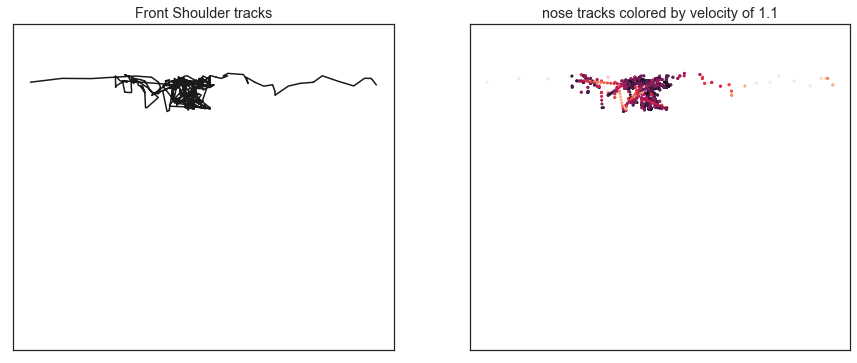

In [34]:
def plot_vel_tracks(node, node_loc, mouse):
    mouse_number = MOUSE_YELLOW_PAGES[mouse]
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    ax1.plot(node_loc[:, 0, mouse_number], node_loc[:, 1, mouse_number], 'k')
    #ax1.set_xlim(0,1024)
    ax1.set_xticks([])
    ax1.set_ylim(0,1024)
    ax1.set_yticks([])
    ax1.set_title('Front Shoulder tracks')

    node_vel = smooth_diff(node_loc[:, :, MOUSE_YELLOW_PAGES[mouse]])   # use thx_vel_fly1 for other fly
    vmin = 0
    vmax = 10

    ax2 = fig.add_subplot(122)
    ax2.scatter(node_loc[:,0,mouse_number], node_loc[:,1,mouse_number], c=node_vel, s=4, vmin=vmin, vmax=vmax)
    #ax2.set_xlim(0,1024)
    
    ax2.set_xticks([])
    ax2.set_ylim(0,1024)
    ax2.set_yticks([])
    ax2.set_title(node+ ' tracks colored by velocity of ' + mouse)

plot_vel_tracks('nose', nose_loc, '1.1')



In [218]:
FIRST_MOUSE=0
SECOND_MOUSE=1

first_mouse_x_loc = front_loc[:, 0, FIRST_MOUSE]
second_mouse__mouse_x_loc = front_loc[:, 0, SECOND_MOUSE]


Text(0.5, 1.0, 'Front Shoulders tracks colored by magnitude of mouse 2.1 speed')

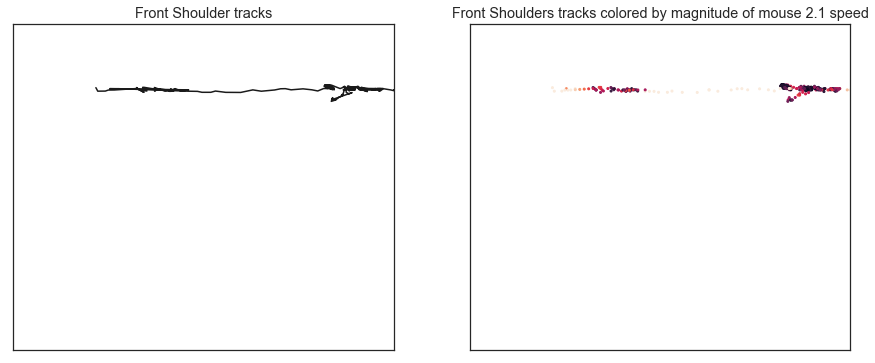

In [219]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(front_loc[:, 0, 1], front_loc[:, 1, 1], 'k')
ax1.set_xlim(0,1024)
ax1.set_xticks([])
ax1.set_ylim(0,1024)
ax1.set_yticks([])
ax1.set_title('Front Shoulder tracks')

kp = front_vel_mouse2_1  # use thx_vel_fly1 for other fly
vmin = 0
vmax = 10

ax2 = fig.add_subplot(122)
ax2.scatter(front_loc[:,0,1], front_loc[:,1,1], c=kp, s=4, vmin=vmin, vmax=vmax)
ax2.set_xlim(0,1024)
ax2.set_xticks([])
ax2.set_ylim(0,1024)
ax2.set_yticks([])
ax2.set_title('Front Shoulders tracks colored by magnitude of mouse 2.1 speed')

In [220]:
import pandas as pd

def corr_roll(datax, datay, win):
    """
    datax, datay are the two timeseries to find correlations between
    
    win sets the number of frames over which the covariance is computed
    
    """
    
    s1 = pd.Series(datax)
    s2 = pd.Series(datay)
    
    return np.array(s2.rolling(win).corr(s1))

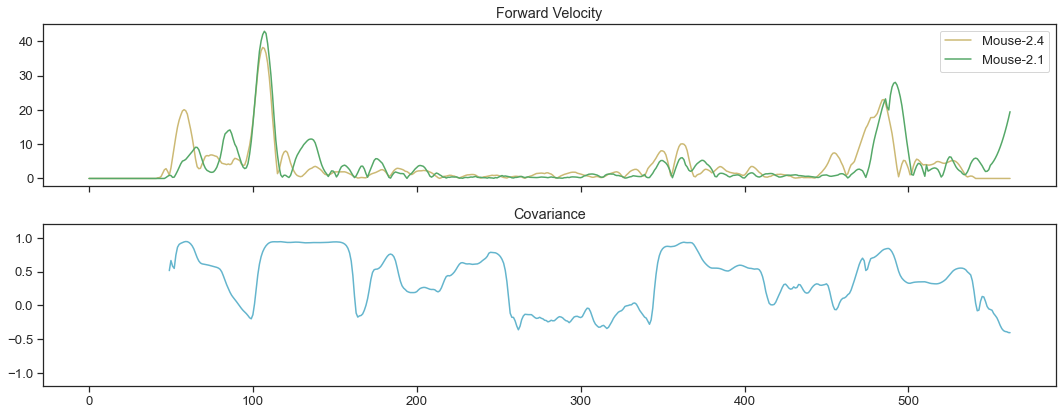

In [221]:
win = 50

cov_vel = corr_roll(front_vel_mouse2_4, front_vel_mouse2_1,win)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,6))
ax[0].plot(front_vel_mouse2_4, 'y', label='Mouse-2.4')
ax[0].plot(front_vel_mouse2_1, 'g', label='Mouse-2.1')
ax[0].legend()
ax[0].set_title('Forward Velocity')
#what is "forward" velocity? when one goes forward the other goes backward? 

ax[1].plot(cov_vel, 'c', markersize=1)
ax[1].set_ylim(-1.2, 1.2)
ax[1].set_title('Covariance')

fig.tight_layout()

# to do 
function for contact
    given two arrays of x values, for nose nodes for m1 and m2, is there contact in each frame, returns an array with boolean (true false) for each frame true = contact
function for visualization 
    given two x location arrays, shows when they are in contact (color change of line) in a track trace, x axis = index = time/frame, y axis is displacement (so left mouse starts at bottom (zero) and right mouse starts at max displacement, distance between tracks should be small for contact )
use contact to define push 
use timeline to define push back vs push
use number of push backs to categorize trial as active or passive 
define retreat 
calculate trial length 

In [222]:
np.where(front_vel_mouse2_4 < 0, front_vel_mouse2_4, False)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

['k', 'k', 'k', 'k', 'k', 'k', 'r', 'r', 'k', 'k', 'k', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'k', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'k', 'k', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r',

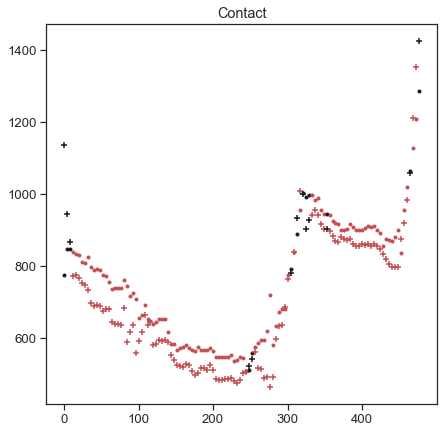

In [99]:
def contact(node_array_m1, node_array_m2, epsilon):
    """
    given two node location arrays for mouse 1 and mouse 1 in one dimension,
    nose nodes recommended for tube test in the x dimension, 
    returns a boolean of the number of frames of the trial/video
    true = contact, false = no contact
    epsilon = threshold for closeness that defines a contact
    """
    contact_array = []
      #get left mouse
      #left of screen in 0 on x axis
    if node_array_m1[0] > node_array_m2[0]:
        left_array = node_array_m2
        right_array = node_array_m1
    else: 
        left_array = node_array_m1
        right_array = node_array_m2
    for i in range(len(node_array_m1)):
        if abs(node_array_m1[i] - node_array_m2[i]) < epsilon:
            contact_array.append(True)
        if left_array[i] > right_array [i]:
            contact_array.append(True)
        else: 
            contact_array.append(False)
    return contact_array
        


nose_m1 = nose_loc[:,0,MOUSE_YELLOW_PAGES['6.1']]
nose_m2 = nose_loc[:,0,MOUSE_YELLOW_PAGES['6.3']]
#thorax_m1 = thorax_loc[:,0, MOUSE_YELLOW_PAGES['5.3']]
#thorax_m2 = thorax_loc[:,0,MOUSE_YELLOW_PAGES['5.4']]

contact(nose_m1, nose_m2,1)


def contact_visualization(node_array_m1, node_array_m2, epsilon):
    contact_array = contact(node_array_m1, node_array_m2, epsilon)
    con_col = [0] * len(contact_array)
    for i in range(len(contact_array)):
        if contact_array[i] == True:
            con_col[i] = 'r'
        else:
            con_col[i] ='k'
    print(con_col)


    plt.figure(figsize=(7,7))
    for i in range(len(node_array_m1)):
        if i%4 == 0:
            plt.scatter(i, node_array_m1[i], c=con_col[i], marker=".")
            plt.scatter(i, node_array_m2[i], c=con_col[i], marker="+")

    #plt.legend()

    #plt.xlim(0,len(node_array_m1))
    #plt.xticks([])

    #max_1 = max(node_array_m1)
    #max_2 = max(node_array_m2)
    #y_max = max(max_1,max_2)

    #plt.ylim(0,y_max)
    #plt.yticks([])
    plt.title('Contact')

contact_visualization(nose_m1, nose_m2, 8)



['k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k']


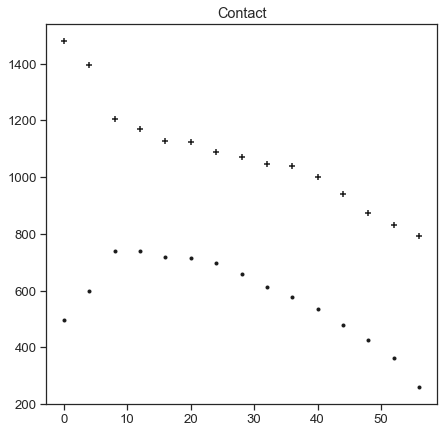

In [88]:
contact_visualization(thorax_m1, thorax_m2, 8)

In [120]:
def push(m1, m2, THETA):
    """ 
    m1 + m2 : strings of mouse IDs
    uses the two nose arrays  
    true = push
    false = no push
    push = if left mouse node is farther to the rigth than right mouse
    theta = threshold for how displaced they need to be for it to be considered a push
    returns an array of len(frames in video) of booleans 
    """
    push_array = []
    node_array_m1 = nose_loc[:,0,MOUSE_YELLOW_PAGES[m1]]
    node_array_m2 = nose_loc[:,0,MOUSE_YELLOW_PAGES[m2]]
      #get left mouse
      #left of screen in 0 on x axis
    if node_array_m1[0] > node_array_m2[0]:
        left_array = node_array_m2
        right_array = node_array_m1
    else: 
        left_array = node_array_m1
        right_array = node_array_m2
    for i in range(len(node_array_m1)):
        if left_array[i] - right_array [i] > THETA:
            push_array.append(True)
        else: 
            push_array.append(False)
    return push_array

    
def push_visualization(m1, m2, theta):
    node_array_m1 = nose_loc[:,0, MOUSE_YELLOW_PAGES[m1]]
    node_array_m2 = nose_loc[:,0, MOUSE_YELLOW_PAGES[m2]]
    push_array = push(m1, m2, theta)
    push_col = [0] * len(push_array)
    for i in range(len(push_array)):
        if push_array[i] == True:
            push_col[i] = 'r'
        else:
            push_col[i] ='k'
    


    plt.figure(figsize=(7,7))
    for i in range(len(node_array_m1)):
     #   if i%4 == 0:
            plt.scatter(i, node_array_m1[i], c=push_col[i], marker=".")
            plt.scatter(i, node_array_m2[i], c=push_col[i], marker="+")



push('5.3', '5.4', 10)


[False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [ ]:
def pushback( ):
    """
    takes in nose node arrays, calls push 
    looks at the node arrays during push in a windowed manner (minimal length of a pushback?)
    if push exceeds a certain length of frames and has minimal x axis displacement
    then the interaction is labeled a pushback
    returns a framelength array of booleans similarly  
    """

def active():
    """
    takes in nose node arrays
    calls pushback 
    any pushback makes a trial active 
    outputs either active or passive label for the trial
    """

In [89]:
def slope_visualization(node_array_m1, node_array_m2, epsilon):
    contact_array = contact(node_array_m1, node_array_m2, epsilon)
    # to be in contact they must be together, so we can take the gradient of
    # either one.
    slope_array = contact_array*np.gradient(node_array_m1)
    con_col = [0] * len(contact_array)
    for i in range(len(contact_array)):
        if slope_array[i] > 0:
            con_col[i] = 'red'
        elif slope_array[i] < 0:
            con_col[i] ='black'
        else:
            con_col[i] = 'white'
    print(con_col)


    plt.figure(figsize=(7,7))
    for i in range(len(node_array_m1)):
        if i%10 == 0:
            plt.scatter(i, node_array_m1[i], c=con_col[i], marker=".")
            plt.scatter(i, node_array_m2[i], c=con_col[i], marker="+")

    #plt.legend()

    #plt.xlim(0,len(node_array_m1))
    #plt.xticks([])

    #max_1 = max(node_array_m1)
    #max_2 = max(node_array_m2)
    #y_max = max(max_1,max_2)

    #plt.ylim(0,y_max)
    #plt.yticks([])
    plt.title('Contact')

slope_visualization(nose_m1, nose_m2, EPSILON)

ValueError: operands could not be broadcast together with shapes (60,) (57,) 

In [90]:
contact_array = contact(nose_m1, nose_m2, EPSILON)
grads = np.gradient(nose_m1)*contact_array
print(np.where(grads > 0, grads, False))


ValueError: operands could not be broadcast together with shapes (57,) (60,) 

In [225]:
def is_push(node_array_m1, node_array_m2, epsilon, win):
    '''
    node_array_m1: an array of x locations for a single mouse
    node_array_m2: same as above, for a mouse starting at the opposite end
    epsilon: slopes are only calculated when they are greater than epsilon
    win: the size of the window over which to calculate the slope
    A push happens when the mouse are in contact and moving
    This is calculated by looking at the slope inside a moving window * contact
    '''

    contact_array = contact(node_array_m1, node_array_m2, epsilon)

    for i in range(len(node_array_m1)):


IndentationError: expected an indented block (2990339737.py, line 13)